C:\Users\rkram\AppData\Local\Temp\ipykernel_26816\1500180774.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MSA', y='Variable', data=msa_df, palette='Blues_d')


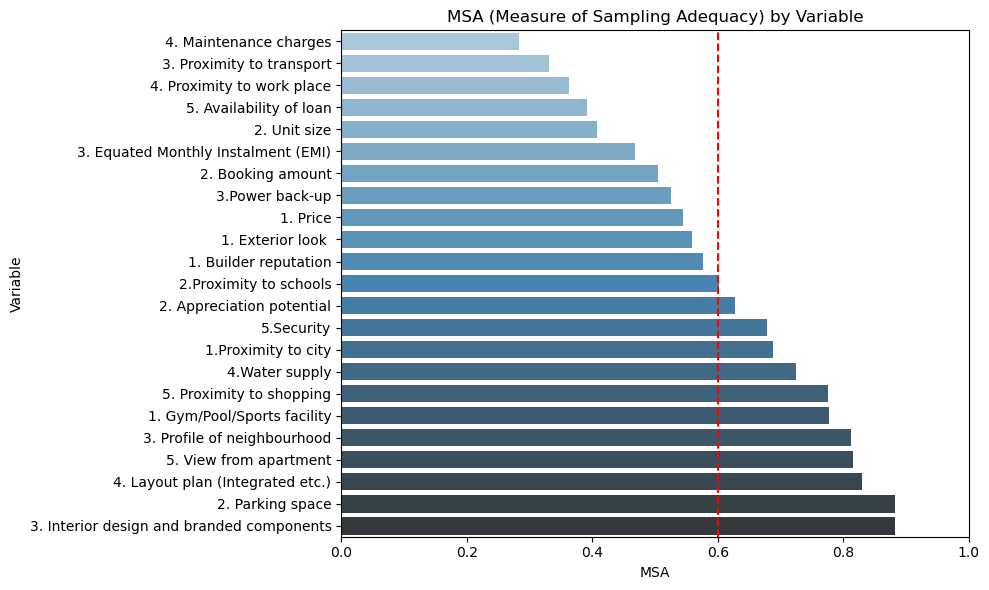

Bartlett's test p-value: 1.0
Factor Loadings (≥ 0.4):
                                            Factor1   Factor2
1.Proximity to city                       -0.000902  0.618029
5. Proximity to shopping                   0.462445  0.401495
1. Gym/Pool/Sports facility                0.541167  0.226750
2. Parking space                           0.432236  0.481151
4.Water supply                             0.614828  0.139861
5.Security                                 0.840149  0.051364
3. Interior design and branded components  0.429330  0.677049
4. Layout plan (Integrated etc.)           0.222381  0.746976
5. View from apartment                     0.514022  0.600718
3. Profile of neighbourhood                0.643979  0.348785


In [1]:
#### PCA and FA ####

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
survey_df = pd.read_csv("D:\\Masters\\VCU\\Classes\\SCMA\\R\\A5\\Survey.csv")

# Select Likert-scale columns (Q17–Q40) → assuming columns 17 to 40 (0-indexed as 16:40)
sur_int = survey_df.iloc[:, 16:40].apply(pd.to_numeric, errors='coerce')

# Remove all-NA and zero-variance columns
sur_int = sur_int.dropna(axis=1, how='all')
sur_int = sur_int.loc[:, sur_int.var(skipna=True) > 0]

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
sur_imputed = pd.DataFrame(imputer.fit_transform(sur_int), columns=sur_int.columns)

# Standardize
scaler = StandardScaler()
sur_scaled = pd.DataFrame(scaler.fit_transform(sur_imputed), columns=sur_imputed.columns)

# KMO Test
kmo_all, kmo_model = calculate_kmo(sur_scaled)
msa_scores = pd.Series(kmo_all, index=sur_scaled.columns)

# Plot MSA
msa_df = msa_scores.round(3).sort_values().reset_index()
msa_df.columns = ['Variable', 'MSA']
plt.figure(figsize=(10, 6))
sns.barplot(x='MSA', y='Variable', data=msa_df, palette='Blues_d')
plt.axvline(0.6, color='red', linestyle='--')
plt.title("MSA (Measure of Sampling Adequacy) by Variable")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Filter MSA ≥ 0.6
valid_vars = msa_scores[msa_scores >= 0.6].index.tolist()
sur_scaled_filtered = sur_scaled[valid_vars]

# Bartlett's test
chi_square_value, p_value = bartlett(*[sur_scaled_filtered[col] for col in sur_scaled_filtered.columns])
print("Bartlett's test p-value:", p_value)

# Factor Analysis (2 factors based on parallel analysis in R)
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(sur_scaled_filtered)
loadings = pd.DataFrame(fa.loadings_, index=sur_scaled_filtered.columns, columns=["Factor1", "Factor2"])
print("Factor Loadings (≥ 0.4):")
print(loadings[(loadings.abs() >= 0.4).any(axis=1)])

C:\Users\rkram\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rkram\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rkram\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rkram\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

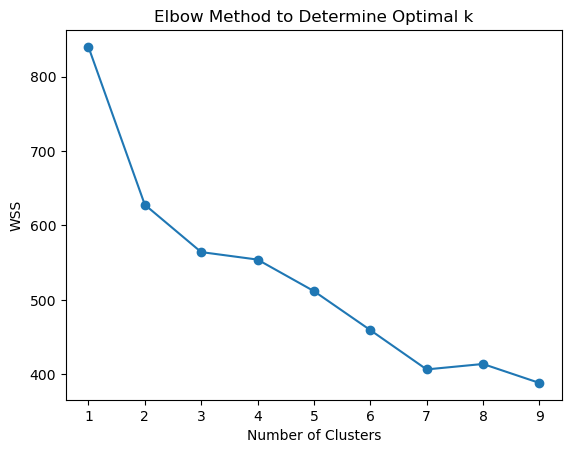

C:\Users\rkram\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster-wise Means:
         1.Proximity to city  2.Proximity to schools  \
cluster                                                
0                   4.041667                3.916667   
1                   3.538462                3.358974   
2                   2.714286                2.285714   

         5. Proximity to shopping  1. Gym/Pool/Sports facility  \
cluster                                                          
0                        3.166667                     4.083333   
1                        2.512821                     2.846154   
2                        1.428571                     2.571429   

         2. Parking space  4.Water supply  5.Security  \
cluster                                                 
0                3.958333        4.291667    4.208333   
1                3.435897        3.769231    3.538462   
2                2.571429        3.428571    2.714286   

         3. Interior design and branded components  \
cluster                     

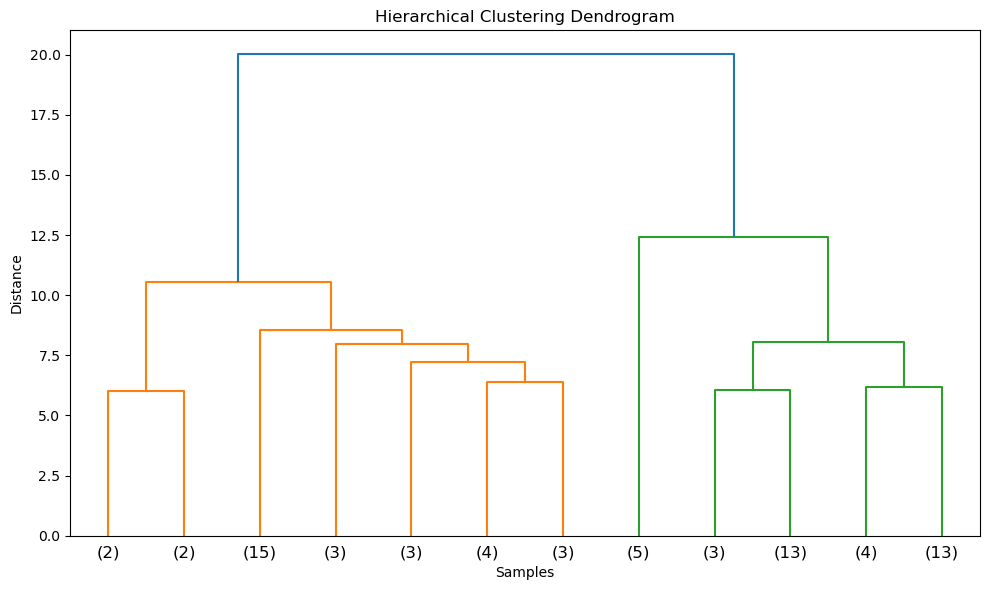

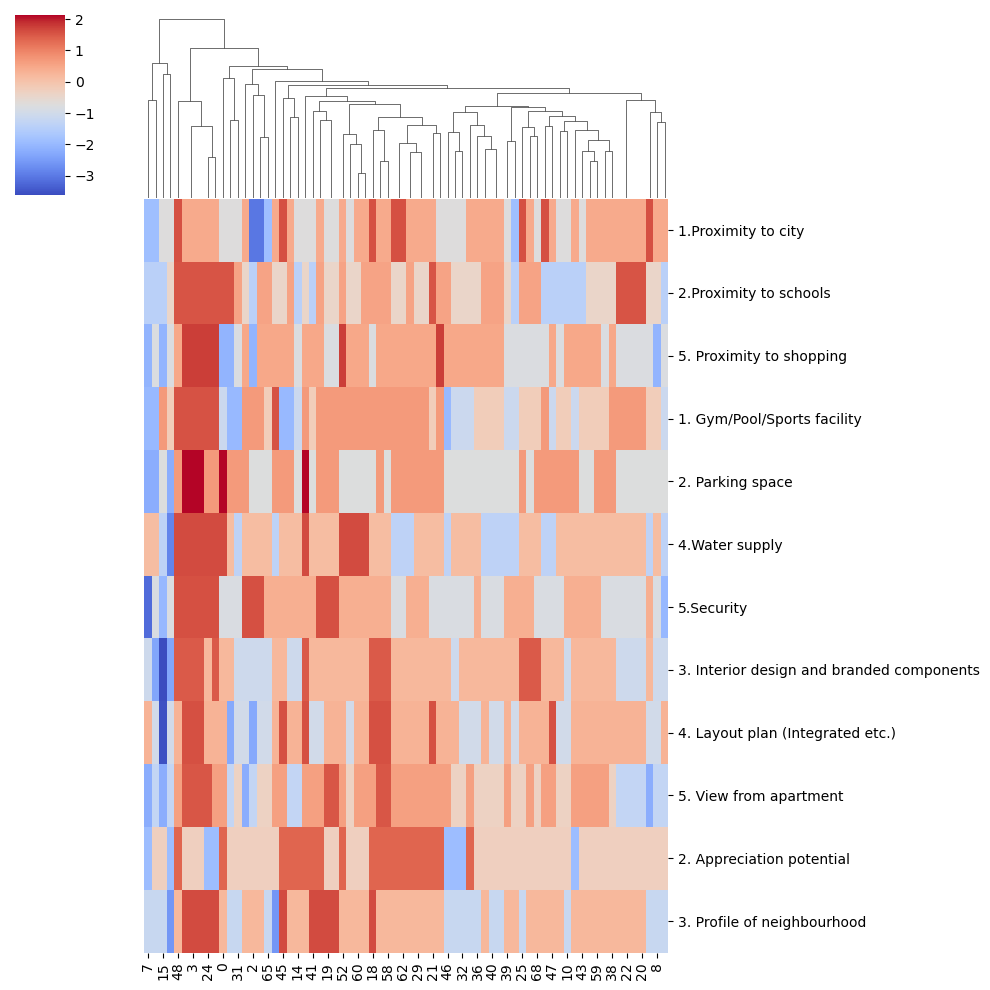

In [2]:
#### Cluster Analysis ####
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

# KMeans Elbow plot
wss = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(sur_scaled_filtered)
    wss.append(km.inertia_)

plt.plot(range(1, 10), wss, marker='o')
plt.title("Elbow Method to Determine Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("WSS")
plt.show()

# Apply KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
survey_df['cluster'] = kmeans.fit_predict(sur_scaled_filtered)

# Cluster-wise means
cluster_summary = survey_df.groupby('cluster')[valid_vars].mean()
print("Cluster-wise Means:")
print(cluster_summary)

# Dendrogram
linked = linkage(sur_scaled_filtered, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='lastp', p=12, show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Heatmap
sns.clustermap(sur_scaled_filtered.T, col_cluster=True, row_cluster=False, cmap="coolwarm")

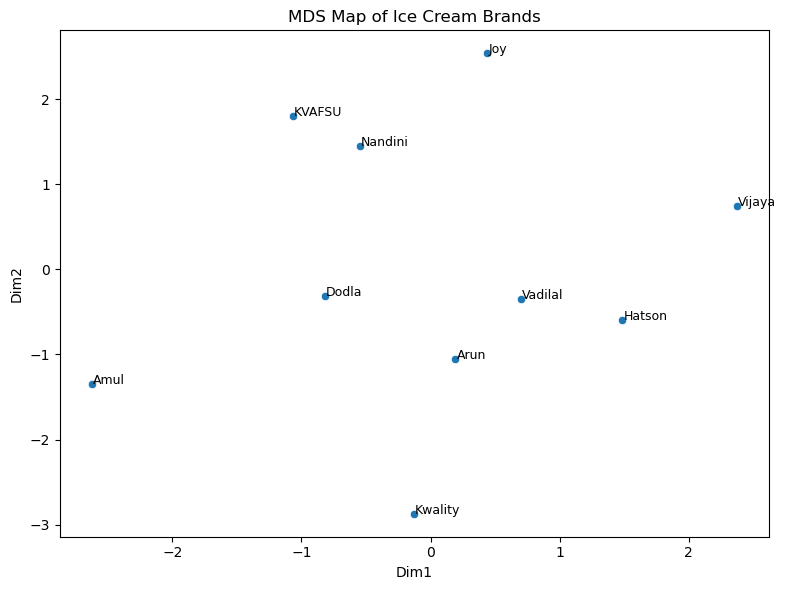

In [3]:
#### Multidimensional Scaling ####
from sklearn.manifold import MDS

# Load ice cream data
icecream = pd.read_csv("D:\\Masters\\VCU\\Classes\\SCMA\\R\\A5\\icecream.csv")
brand_names = icecream["Brand"]
attr_data = icecream.drop(columns=["Brand"])

# Apply Classical MDS
mds = MDS(n_components=2, dissimilarity='euclidean', random_state=42)
mds_coords = mds.fit_transform(attr_data)

mds_df = pd.DataFrame(mds_coords, columns=["Dim1", "Dim2"])
mds_df["Brand"] = brand_names

# Plot MDS
plt.figure(figsize=(8, 6))
sns.scatterplot(data=mds_df, x="Dim1", y="Dim2")
for i in range(len(mds_df)):
    plt.text(mds_df["Dim1"][i]+0.01, mds_df["Dim2"][i], mds_df["Brand"][i], fontsize=9)
plt.title("MDS Map of Ice Cream Brands")
plt.tight_layout()
plt.show()


C:\Users\rkram\AppData\Local\Temp\ipykernel_26816\1062119085.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values, y=importance.index, palette="Blues_d")


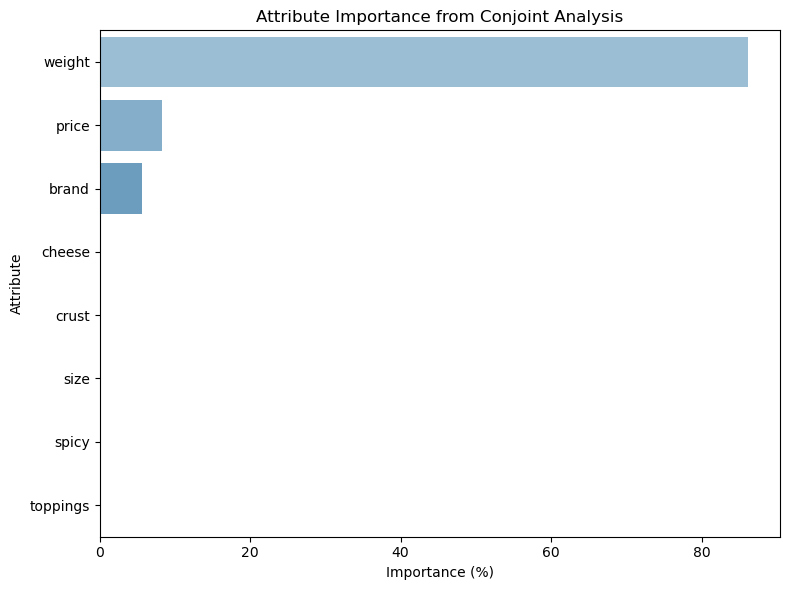

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
pizza = pd.read_csv("D:\\Masters\\VCU\\Classes\\SCMA\\R\\A5\\pizza_data.csv")

# Step 1: Separate target and predictors
y = pizza["ranking"]
X_raw = pizza.drop(columns=["ranking"])

# Step 2: One-hot encode all categorical variables
X = pd.get_dummies(X_raw, drop_first=True)

# Step 3: Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Step 4: Extract coefficients
coefs = pd.Series(model.coef_, index=X.columns)

# Step 5: Calculate attribute importance
attribute = coefs.index.str.extract(r"^([a-zA-Z]+)")[0]
coefs_df = pd.DataFrame({"attribute": attribute, "coef": coefs.values})

importance = coefs_df.groupby("attribute")["coef"].agg(lambda x: x.max() - x.min())
importance = (importance / importance.sum() * 100).round(1).sort_values(ascending=False)

# Step 6: Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=importance.values, y=importance.index, palette="Blues_d")
plt.title("Attribute Importance from Conjoint Analysis")
plt.xlabel("Importance (%)")
plt.ylabel("Attribute")
plt.tight_layout()
plt.show()